In [1]:
import numpy as np #matrix operations
import matplotlib.pyplot as plt #graphs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers

#### Mengambil data stock prices dari yfinance

In [4]:
tlkm = yf.download("TLKM.JK", start='2015-12-22', end='2020-12-22')

tlkm['Date'] = tlkm.index
tlkm_prices = tlkm[['Close']]
tlkm_dates = tlkm[['Date']]

[*********************100%***********************]  1 of 1 completed



In [5]:
tlkm['Dividends'] = pd.Series(0,index=tlkm.index)

In [8]:
print(tlkm)

              Open    High     Low   Close    Adj Close     Volume       Date  \
Date                                                                            
2015-12-22  3100.0  3135.0  3100.0  3135.0  2916.623779   68929200 2015-12-22   
2015-12-23  3075.0  3145.0  3020.0  3110.0  2893.365234   92014400 2015-12-23   
2015-12-28  3090.0  3170.0  3090.0  3120.0  2902.668701   47634200 2015-12-28   
2015-12-29  3100.0  3120.0  3075.0  3095.0  2879.410156   38486500 2015-12-29   
2015-12-30  3100.0  3135.0  3100.0  3105.0  2888.713623   40956100 2015-12-30   
...            ...     ...     ...     ...          ...        ...        ...   
2020-12-15  3320.0  3490.0  3290.0  3450.0  3450.000000  410175700 2020-12-15   
2020-12-16  3500.0  3640.0  3500.0  3610.0  3610.000000  455088400 2020-12-16   
2020-12-17  3610.0  3620.0  3520.0  3540.0  3540.000000  249797800 2020-12-17   
2020-12-18  3500.0  3540.0  3500.0  3510.0  3510.000000  187856600 2020-12-18   
2020-12-21  3530.0  3610.0  

#### Generate training set

In [10]:
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close,
                              length=value_num,
                              batch_size=len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0            
        global_index += 1
    return np.concatenate((i, np.transpose([has_dividends])),
                           axis=1), t

In [11]:
inputs, targets = generate_series(tlkm, 4)

In [12]:
print(inputs[1257])

[3450. 3610. 3540. 3510.    0.]
[3450. 3610. 3540. 3510.    0.]


#### Normalisasi data

In [13]:
h_min = tlkm.min()
normalized_h = (tlkm - h_min) / (tlkm.max() - h_min)

In [14]:
inputs, targets = generate_series(normalized_h, 4)

In [15]:
print(inputs[1257])

[0.39732143 0.46875    0.4375     0.42410714 0.        ]
[0.39732143 0.46875    0.4375     0.42410714 0.        ]


In [16]:
def create_model(n):
    m = Sequential()
    m.add(layers.Dense(64, activation='relu', input_shape=(n+1,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(1))
    return m

In [17]:
train_inputs = inputs[:-1000]
val_inputs = inputs[-1000:]
train_targets = targets[:-1000]
val_targets = targets[-1000:]

#### Mencari parameter paling optimal untuk input nya

In [19]:
def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end+1):
        print('Using {} inputs'.format(inputs))
        model_inputs, targets = generate_series(data, inputs)
        
        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]
        
        m = create_model(inputs)
        print('Training')
        m.compile(optimizer='adam', loss='mse') 
        h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_inputs, val_targets))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
    return models

In [20]:
trained_models = select_inputs(normalized_h, 2, 10, 20)

Using 2 inputs
Using 2 inputs
Training
Epoch 1/20
Training
Epoch 1/20
9/9 [==============================] - 2s 128ms/step - loss: 0.1052 - val_loss: 0.0125
Epoch 2/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 3/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0035
Epoch 4/20
Epoch 4/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 5/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/20
9/9 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/20
9/9 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/20
9/9 [==============================] - 0s 12

Epoch 14/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 15/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 16/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 17/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 18/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 19/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 20/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0018
Using 4 inputs
Using 4 inputs
Training
Epoch 1/20
Training
Epoch 1/20
9/9 [==============================] - 1s 27ms/step - loss: 0.1365 - val_loss: 0.0052
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0170
Epoch 3/20
9/9 [==============================] - 0s 11ms/ste

9/9 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 7/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 9/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 11/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 12/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 13/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 14/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 15/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 16/20
9/9 [==================

8/8 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 19/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 20/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Using 7 inputs
Using 7 inputs
Training
Epoch 1/20
Training
Epoch 1/20
8/8 [==============================] - 1s 30ms/step - loss: 0.0405 - val_loss: 0.0172
Epoch 2/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0108 - val_loss: 0.0025
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 4/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0014

8/8 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/20
Epoch 11/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 12/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 13/20
8/8 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 14/20
Epoch 14/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 15/20
Epoch 15/20
8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 16/20
8/8 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 17/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 18/20
8/8 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 19/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0

8/8 [==============================] - 0s 12ms/step - loss: 0.0134 - val_loss: 0.0028
Epoch 4/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 5/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 6/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 11/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 12/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 13/20
8/8 [=====================

In [21]:
trained_models

{2: {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1451ea1c0>,
  'history': {'loss': [0.07809260487556458,
    0.0047112274914979935,
    0.008241002447903156,
    0.001977577107027173,
    0.0018606736557558179,
    0.0013274216325953603,
    0.0013002282939851284,
    0.0011650524102151394,
    0.0011357986368238926,
    0.0010986949782818556,
    0.0010840414324775338,
    0.0010592570761218667,
    0.0010490561835467815,
    0.001012536115013063,
    0.0009943292243406177,
    0.0009881481528282166,
    0.0009864690946415067,
    0.0009573716088198125,
    0.0009442346636205912,
    0.0009381892741657794],
   'val_loss': [0.01254697609692812,
    0.009148835204541683,
    0.0034739843104034662,
    0.002718001138418913,
    0.0018980320310220122,
    0.0017028143629431725,
    0.0015330561436712742,
    0.0015753653133288026,
    0.0014476864598691463,
    0.00141405058093369,
    0.0013713289517909288,
    0.0013616130454465747,
    0.0013055443996563554,
   

{2: {'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1451ea1c0>,
  'history': {'loss': [0.07809260487556458,
    0.0047112274914979935,
    0.008241002447903156,
    0.001977577107027173,
    0.0018606736557558179,
    0.0013274216325953603,
    0.0013002282939851284,
    0.0011650524102151394,
    0.0011357986368238926,
    0.0010986949782818556,
    0.0010840414324775338,
    0.0010592570761218667,
    0.0010490561835467815,
    0.001012536115013063,
    0.0009943292243406177,
    0.0009881481528282166,
    0.0009864690946415067,
    0.0009573716088198125,
    0.0009442346636205912,
    0.0009381892741657794],
   'val_loss': [0.01254697609692812,
    0.009148835204541683,
    0.0034739843104034662,
    0.002718001138418913,
    0.0018980320310220122,
    0.0017028143629431725,
    0.0015330561436712742,
    0.0015753653133288026,
    0.0014476864598691463,
    0.00141405058093369,
    0.0013713289517909288,
    0.0013616130454465747,
    0.0013055443996563554,
   

In [22]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss}

#### Plot the test error depending on the network’s input number

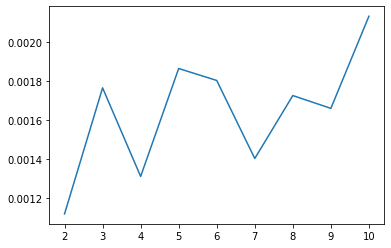

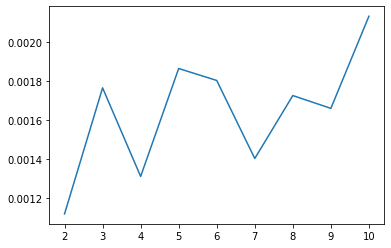

In [23]:
val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)

In [24]:
close_min = tlkm['Close'].min()
close_max = tlkm['Close'].max()
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    print(k, e)

2 2562.5089520961046
3 2563.9529891312122
4 2562.938207425177
5 2564.17459461838
6 2564.0375958010554
7 2563.1438602879643
8 2563.864689953625
9 2563.7179297208786
10 2564.773191586137
2 2562.5089520961046
3 2563.9529891312122
4 2562.938207425177
5 2564.17459461838
6 2564.0375958010554
7 2563.1438602879643
8 2563.864689953625
9 2563.7179297208786
10 2564.773191586137


# Prediction

In [25]:
inputs = min(indices)

In [26]:
model_inputs, targets = generate_series(normalized_h, inputs)

In [27]:
train_inputs = model_inputs[:-1000]
val_inputs = model_inputs[-1000:]
train_targets = targets[:-1000]
val_targets = targets[-1000:]

In [32]:
m = create_model(inputs)
print('Training')
m.compile(optimizer='adam', loss='mse') 
h = m.fit(train_inputs, train_targets,
          epochs=100,
          batch_size=32,
          validation_data=(val_inputs, val_targets))

val_pred = m.predict(val_inputs,batch_size=32)

Training
Epoch 1/100
Training
Epoch 1/100
9/9 [==============================] - 1s 39ms/step - loss: 0.2902 - val_loss: 0.1493
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 0.1025 - val_loss: 0.0363
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 0.0047
Epoch 4/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0045 - val_loss: 0.0088
Epoch 5/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 6/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 8/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 9/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 10/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0024 - val_lo

9/9 [==============================] - 0s 10ms/step - loss: 9.6682e-04 - val_loss: 0.0011
Epoch 34/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 35/100
9/9 [==============================] - 0s 10ms/step - loss: 9.5788e-04 - val_loss: 0.0011
Epoch 36/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 37/100
9/9 [==============================] - 0s 10ms/step - loss: 8.8041e-04 - val_loss: 0.0011
Epoch 38/100
9/9 [==============================] - 0s 10ms/step - loss: 9.5246e-04 - val_loss: 0.0011
Epoch 39/100
9/9 [==============================] - 0s 10ms/step - loss: 8.0958e-04 - val_loss: 0.0011
Epoch 40/100
9/9 [==============================] - 0s 10ms/step - loss: 8.0804e-04 - val_loss: 0.0011
Epoch 41/100
9/9 [==============================] - 0s 10ms/step - loss: 8.2371e-04 - val_loss: 0.0011
Epoch 42/100
9/9 [==============================] - 0s 10ms/step - loss: 8.8714e-04 - val_loss

Epoch 64/100Epoch 64/100
9/9 [==============================] - 0s 12ms/step - loss: 8.9465e-04 - val_loss: 0.0010
Epoch 65/100
9/9 [==============================] - 0s 12ms/step - loss: 9.0559e-04 - val_loss: 0.0010
Epoch 66/100
9/9 [==============================] - 0s 12ms/step - loss: 8.8221e-04 - val_loss: 0.0010
Epoch 67/100
9/9 [==============================] - 0s 12ms/step - loss: 9.8471e-04 - val_loss: 0.0010
Epoch 68/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 69/100
9/9 [==============================] - 0s 10ms/step - loss: 8.0606e-04 - val_loss: 0.0010
Epoch 70/100
9/9 [==============================] - 0s 10ms/step - loss: 8.1724e-04 - val_loss: 0.0010
Epoch 71/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 72/100
9/9 [==============================] - 0s 10ms/step - loss: 7.7881e-04 - val_loss: 0.0010
Epoch 73/100
9/9 [==============================] - 0s 10ms/step - lo

9/9 [==============================] - 0s 10ms/step - loss: 8.9646e-04 - val_loss: 0.0010
Epoch 95/100
9/9 [==============================] - 0s 12ms/step - loss: 8.2470e-04 - val_loss: 9.9957e-04
Epoch 96/100
9/9 [==============================] - 0s 12ms/step - loss: 7.9056e-04 - val_loss: 0.0010
Epoch 97/100
9/9 [==============================] - 0s 11ms/step - loss: 8.3044e-04 - val_loss: 9.9427e-04
Epoch 98/100
9/9 [==============================] - 0s 10ms/step - loss: 8.2302e-04 - val_loss: 9.9507e-04
Epoch 99/100
9/9 [==============================] - 0s 10ms/step - loss: 7.5364e-04 - val_loss: 0.0010
Epoch 100/100
9/9 [==============================] - 0s 10ms/step - loss: 8.1497e-04 - val_loss: 9.9726e-04


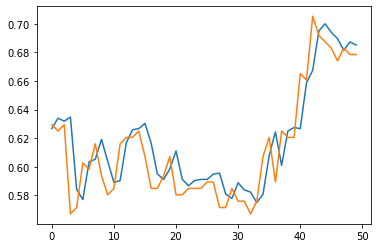

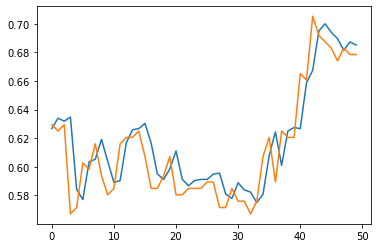

In [33]:
plt.plot(val_pred[:50])
plt.plot(val_targets[:50])

In [34]:
h_min = tlkm.min()
tlkm_targets = (val_targets * tlkm.max()['Close'] - h_min['Close']) + h_min['Close']
tlkm_pred = (val_pred * tlkm.max()['Close'] - h_min['Close']) + h_min['Close']

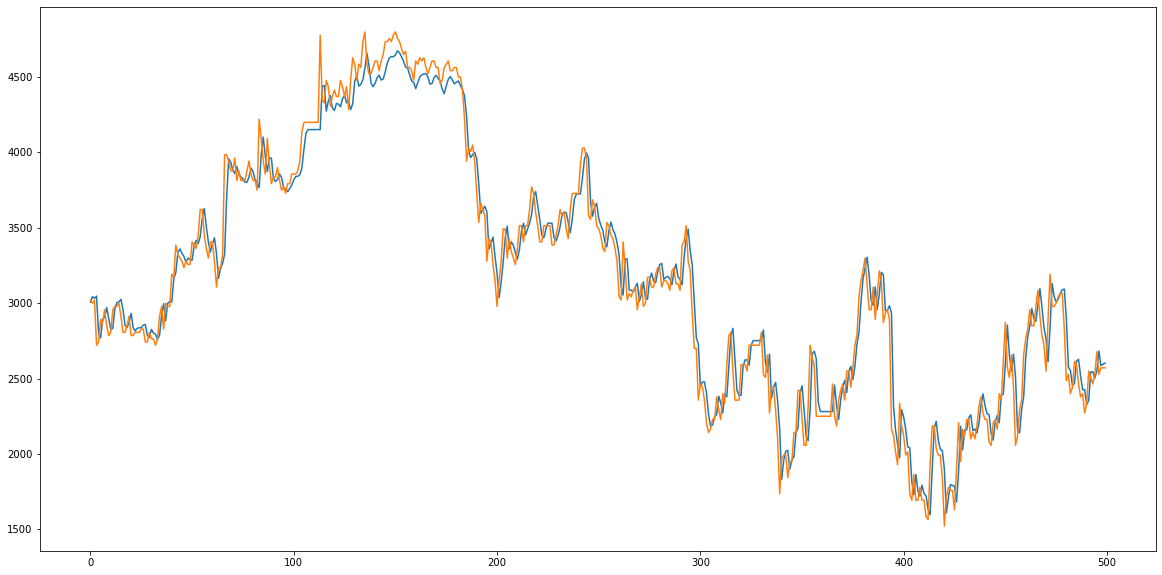

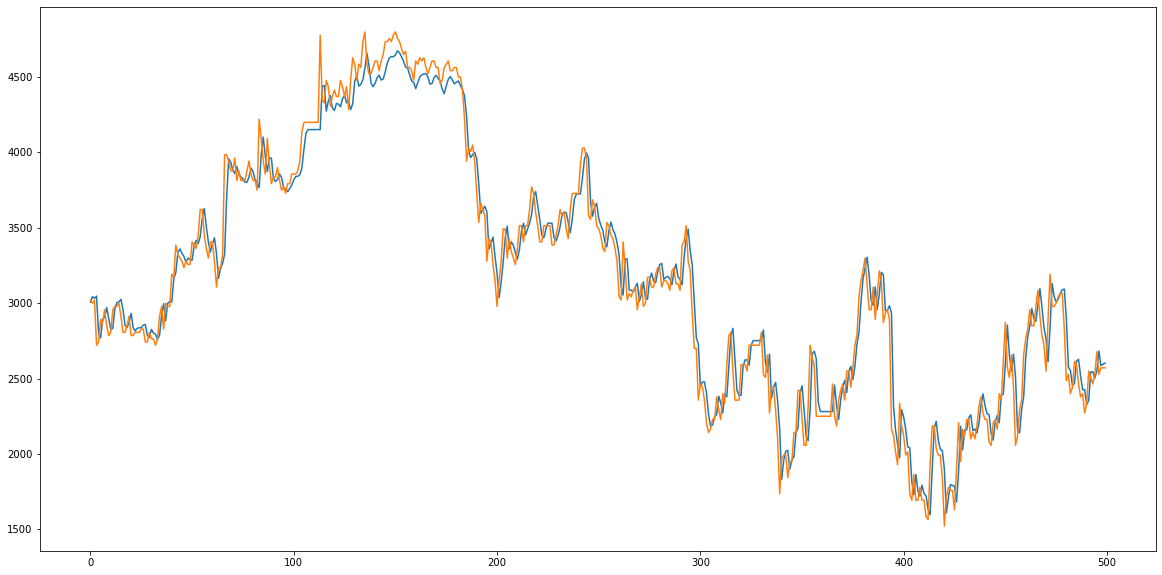

In [40]:
plt.figure(figsize=(20,10))
plt.plot(tlkm_pred[:500])
plt.plot(tlkm_targets[:500])